In [27]:
import csv
from datasets import load_dataset
import numpy as np
import random
import sklearn
from sklearn.calibration import calibration_curve, CalibrationDisplay
from transformers import AutoTokenizer, DistilBertModel, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import evaluate
import tensorflow as tf # pip install tensorflow (python recommended, conda not recommended)
import tensorflow_probability as tfp # needs pip install --upgrade tensorflow-probability
import torch
from torch import nn
import calibration as cal
import matplotlib.pyplot as plt


## Read in dataset and preprocessing

In [2]:
# read in datasets 
train_data = load_dataset('csv', data_files = ['./data/train.csv'], split = 'train')
test_data = load_dataset('csv', data_files = ['./data/test.csv'], split = 'train')
val_data = load_dataset('csv', data_files = ['./data/val.csv'], split = 'train')

Found cached dataset csv (/Users/evaborton/.cache/huggingface/datasets/csv/default-76f4561a5d09d81a/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Found cached dataset csv (/Users/evaborton/.cache/huggingface/datasets/csv/default-ad923bfcbd98d74f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Found cached dataset csv (/Users/evaborton/.cache/huggingface/datasets/csv/default-cae2e8605801748c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [3]:
# Preprocess
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
# preprocessing function: tokenize tweet and truncate to be no longer than max length
def preprocess_function(examples):
    return tokenizer(examples["tweet"], truncation=True)

In [5]:
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_val = val_data.map(preprocess_function, batched=True)

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Evaluate

In [7]:
accuracy = evaluate.load("accuracy")

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Load models / Train them if not trained yet

In [9]:
id2label = {0: "FAKE", 1: "REAL"}
label2id = {"FAKE": 0, "REAL": 1}

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [11]:
def build_trainer(train, test, output_dir, resume_from_checkpoint):
    
    # define training hyperparameters 
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        resume_from_checkpoint = resume_from_checkpoint
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    return trainer

In [12]:
trainer = build_trainer(tokenized_train, tokenized_test, "modelA", "modelA/checkpoint-402")

trainer.train(resume_from_checkpoint = "./modelA/checkpoint-402")

Loading model from ./modelA/checkpoint-402.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6420
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 402
  Number of trainable parameters = 66955010
  Continuing training from checkpoint, will skip

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from modelA/checkpoint-402 (score: 0.12317584455013275).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=402, training_loss=0.0, metrics={'train_runtime': 0.0948, 'train_samples_per_second': 67738.047, 'train_steps_per_second': 4241.541, 'total_flos': 169064622239376.0, 'train_loss': 0.0, 'epoch': 1.0})

# How calibrated is this model?

In [14]:
output = trainer.predict(tokenized_test) # get the logits & predicted labels

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [28]:
# get true labels
y_true = np.array([test_data[i]["label"] for i in range(test_data.num_rows)])

In [29]:
# get the logits 
y_logits = output.predictions 

In [30]:
# transform np.array to tensor (so we can use softmax)
y_logits_torch = torch.from_numpy(y_logits) # logits in tensor form 

In [31]:
#probabilities = nn.functional.softmax(y_logits_torch, axis=1)
probabilities = tf.nn.softmax(y_logits_torch, axis=1)

In [32]:
# transform back to np.array for sklearn calibration functions 
y_prob = np.array(probabilities) # predicted probabilities 
y_prob_pos = np.array([y_prob[i][1] for i in range(y_prob.shape[0])]) # predicted probabilities for positive class 
y_prob_pos

array([9.9840075e-01, 4.7943523e-04, 6.2409189e-04, ..., 9.9832314e-01,
       9.9788243e-01, 9.9686486e-01], dtype=float32)

In [33]:
# n_bins default is 5
prob_true, prob_pred = sklearn.calibration.calibration_curve(y_true, y_prob_pos, n_bins = 5)

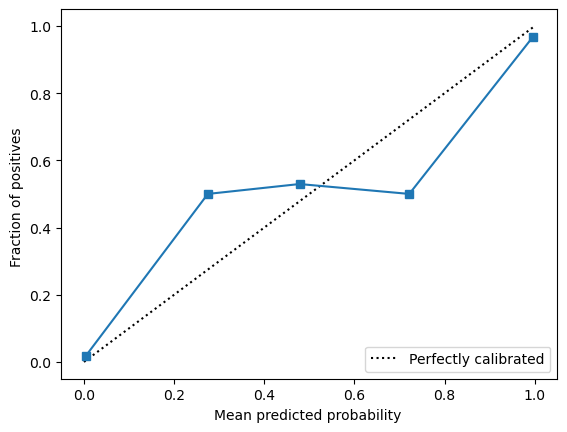

In [34]:
# reliability diagram 
disp = CalibrationDisplay(prob_true, prob_pred, y_prob_pos)
disp.plot()

In [35]:
# get first arg— just the logits
logits = [logit[1] for logit in output.predictions]
logits = torch.FloatTensor(logits)
logits

tensor([ 3.6756, -3.4124, -3.3328,  ...,  3.6666,  3.4992,  3.3635])

In [36]:
# check ECE
calibration_error = cal.get_calibration_error(y_prob_pos, y_true)
calibration_error

0.05856086045683694

## What about the smaller models?

In [68]:
predict_100 = []

for i in range(4):
    train = tokenized_train.select(random.sample(range(tokenized_train.num_rows), k=100))
    trainer = build_trainer(train, tokenized_test, "model100_" + str(i + 1), "model100_" + str(i + 1) + "/checkpoint-7")

    trainer.train(resume_from_checkpoint="model100_" + str(i + 1) + "/checkpoint-7")
    
    predict_100.append(trainer.predict(tokenized_test))

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from model100_1/checkpoint-7.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model100_1/checkpoint-7 (score: 0.1716984510421753).


Epoch,Training Loss,Validation Loss


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from model100_2/checkpoint-7.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model100_2/checkpoint-7 (score: 0.16911059617996216).


Epoch,Training Loss,Validation Loss


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from model100_3/checkpoint-7.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model100_3/checkpoint-7 (score: 0.18475455045700073).


Epoch,Training Loss,Validation Loss


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from model100_4/checkpoint-7.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model100_4/checkpoint-7 (score: 0.19567905366420746).


Epoch,Training Loss,Validation Loss


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


In [69]:
predict_400 = []

for i in range(4):
    train = tokenized_train.select(random.sample(range(tokenized_train.num_rows), k=100))
    trainer = build_trainer(train, tokenized_test, "model400_" + str(i + 1), "model400_" + str(i + 1) + "/checkpoint-25")

    trainer.train(resume_from_checkpoint="model400_" + str(i + 1) + "/checkpoint-25")
    
    predict_400.append(trainer.predict(tokenized_test))

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from model400_1/checkpoint-25.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/evaborton/miniconda3/envs/cs375/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples =

  0%|          | 0/4 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from model400_1/checkpoint-25 (score: 0.2212168425321579).


Epoch,Training Loss,Validation Loss


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


KeyboardInterrupt: 

# Calibration

## Setup

In [37]:
# Copied from sklearn.CalibrationClassifierCV source code
# refer to function fit in source code to see how this is used 
from math import log
from scipy.special import expit
from scipy.special import xlogy
from scipy.optimize import fmin_bfgs

def _sigmoid_calibration(predictions, y, sample_weight=None):
    """
    Probability Calibration with sigmoid method (Platt 2000)
    predictions = (uncalibrated) predicted probabilities from classifier 
    y = true labels (0 or -1 for negative and 1 for positive)
    sample_weight = I just ignored this 
    """
#     predictions = column_or_1d(predictions)
#     y = column_or_1d(y)

    F = predictions  # F follows Platt's notations

    # Bayesian priors (see Platt end of section 2.2):
    # It corresponds to the number of samples, taking into account the
    # `sample_weight`.
    mask_negative_samples = y <= 0
    if sample_weight is not None:
        prior0 = (sample_weight[mask_negative_samples]).sum()
        prior1 = (sample_weight[~mask_negative_samples]).sum()
    else:
        prior0 = float(np.sum(mask_negative_samples)) #number of negative samples 
        prior1 = y.shape[0] - prior0 #number of positive samples 
    # The T are the t_i's in the paper 
    T = np.zeros_like(y, dtype=np.float64) # same shape as y, but all zeros
    T[y > 0] = (prior1 + 1.0) / (prior1 + 2.0)
    T[y <= 0] = 1.0 / (prior0 + 2.0)
    T1 = 1.0 - T

    def objective(AB):
        # From Platt (beginning of Section 2.2)
        P = expit(-(AB[0] * F + AB[1]))
        loss = -(xlogy(T, P) + xlogy(T1, 1.0 - P))
        if sample_weight is not None:
            return (sample_weight * loss).sum()
        else:
            return loss.sum()

    def grad(AB):
        # gradient of the objective function
        P = expit(-(AB[0] * F + AB[1]))
        TEP_minus_T1P = T - P
        if sample_weight is not None:
            TEP_minus_T1P *= sample_weight
        dA = np.dot(TEP_minus_T1P, F)
        dB = np.sum(TEP_minus_T1P)
        return np.array([dA, dB])

    AB0 = np.array([0.0, log((prior0 + 1.0) / (prior1 + 1.0))]) #initial values 
    AB_ = fmin_bfgs(objective, AB0, fprime=grad, disp=False)
    return AB_[0], AB_[1]

In [38]:
y_logits_val = trainer.predict(tokenized_val).predictions # logits of val set 

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet, id. If tweet, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2140
  Batch size = 16


In [39]:
# transform np.array to tensor (so we can use softmax)
y_logits_val_tf = torch.from_numpy(y_logits_val) # logits in tensor form
# get predicted probabilites by using softmax 
probabilities_val = tf.nn.softmax(y_logits_val_tf, axis=1)
# transform back to np.array 
y_prob_tmp = np.array(probabilities_val) # predicted probabilities - both classes
y_prob_val = np.array([y_prob_tmp[i][1] for i in range(y_prob_tmp.shape[0])]) # predicted probs for positive class (val data)
# true labels 
y_true_val = np.array([val_data[i]["label"] for i in range(val_data.num_rows)])

## Platt Scaling

In [53]:
a, b = _sigmoid_calibration(y_prob_val, y_true_val) # a, b got from logistic regression on val set 
platt_preds = expit(-(a * y_prob_pos + b)) # apply platt scaling

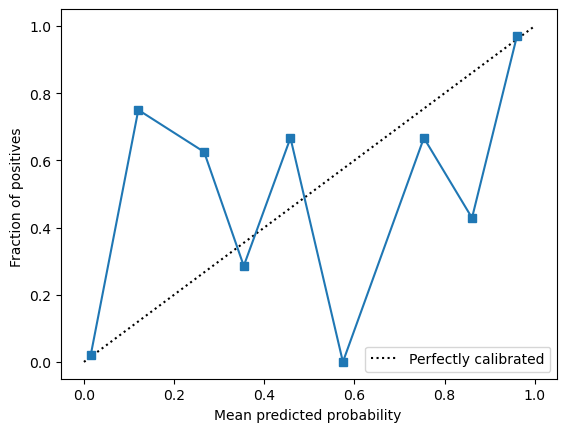

In [117]:
# y_true: actual labels 
# platt_preds: predicted probabilities for pos class 
prob_true_cal, prob_pred_cal = sklearn.calibration.calibration_curve(y_true, platt_preds, n_bins = 10)
disp_cal = CalibrationDisplay(prob_true_cal, prob_pred_cal, platt_preds)
disp_cal.plot()

In [59]:
# calculate ECE
calibration_error = cal.get_calibration_error(platt_preds, y_true)
calibration_error

0.060660448543836766

## Novel Method: Inverse Sigmoid Scaling

In [113]:
a = -1 # any number you want as long as it's negative

# apply inverse of sigmoid
calibrated_preds = (np.log((1-y_prob_pos)/y_prob_pos))/a

# linear map to 0-1 range
min_cal = min(calibrated_preds)
max_cal = max(calibrated_preds)
range_cal = max_cal - min_cal

# calibrated probabilities 
inverse_sigmoid_preds = np.array([(elem - min_cal) / range_cal for elem in calibrated_preds])

calibrated_preds

array([ 6.436619 , -7.642422 , -7.3785887, ...,  6.3891554,  6.155364 ,
        5.76194  ], dtype=float32)

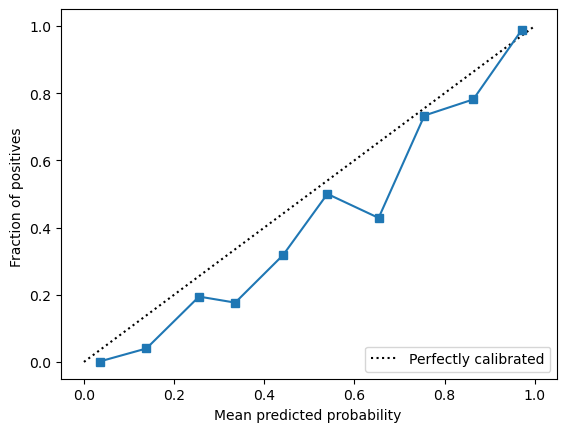

In [116]:
prob_true_cal, prob_pred_cal = sklearn.calibration.calibration_curve(y_true, inverse_sigmoid_preds, n_bins = 10)
disp_cal = CalibrationDisplay(prob_true_cal, prob_pred_cal, inverse_sigmoid_preds)
disp_cal.plot()

In [115]:
# calculate ECE
calibration_error = cal.get_calibration_error(inverse_sigmoid_preds, y_true)
calibration_error

0.043675877506635194

## Overall ECE Comparison

### Uncalibrated

In [65]:
calibration_error = cal.get_calibration_error(y_prob_pos, y_true)
calibration_error

0.05856086045683694

### Platt Scaling

In [66]:
calibration_error = cal.get_calibration_error(platt_preds, y_true)
calibration_error

0.060660448543836766

### Inverse Sigmoid Scaling

In [67]:
calibration_error = cal.get_calibration_error(inverse_sigmoid_preds, y_true)
calibration_error

0.043675878623873864

## Smaller Models